<a href="https://colab.research.google.com/github/bintangfikrif/Unnamed-Final_Project/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset



In [10]:
try:
    df = pd.read_csv('spatial-metrics-indonesia-remaining_forest_kabupaten.csv')
    display(df.head(10))
except FileNotFoundError:
    print("Error: File not found. Please ensure the file 'spatial-metrics-indonesia-remaining_forest_kabupaten.csv' exists in the current directory.")
    df = None # Assign None to df in case of error
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares
0,2001,INDONESIA,ID,ACEH BARAT,ID-1107,ACEH,ID-11,215737.764000
1,2001,INDONESIA,ID,ACEH BARAT DAYA,ID-1112,ACEH,ID-11,220655.913176
2,2001,INDONESIA,ID,ACEH BESAR,ID-1108,ACEH,ID-11,251780.389059
3,2001,INDONESIA,ID,ACEH JAYA,ID-1116,ACEH,ID-11,50390.654471
4,2001,INDONESIA,ID,ACEH SELATAN,ID-1103,ACEH,ID-11,710227.314705
5,2001,INDONESIA,ID,ACEH SINGKIL,ID-1102,ACEH,ID-11,242695.767177
6,2001,INDONESIA,ID,ACEH TAMIANG,ID-1114,ACEH,ID-11,15691.762588
7,2001,INDONESIA,ID,ACEH TENGAH,ID-1106,ACEH,ID-11,394550.701765
8,2001,INDONESIA,ID,ACEH TENGGARA,ID-1104,ACEH,ID-11,435701.217881
9,2001,INDONESIA,ID,ACEH TIMUR,ID-1105,ACEH,ID-11,539882.881762


## Data Exploration

In [11]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine the data types of each column
print("\nData types of each column:\n", df.dtypes)

# Generate descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:\n", df.describe())

# Identify unique values and their frequencies for categorical columns
categorical_cols_to_explore = ['country', 'country_iso2', 'region', 'parent_region']

for col in categorical_cols_to_explore:
    # Add a check to ensure the column exists before trying to access it
    if col in df.columns:
        print(f"\nUnique values and counts for {col}:")
        print(df[col].value_counts())
    else:
        print(f"Column '{col}' not found in the DataFrame during exploration.")


# Check for missing values
print("\nMissing values in each column:\n", df.isnull().sum())


# Analyze relationships between numerical and categorical (example: forest area by region)
print("\nMean Forest Area by Region:\n", df.groupby('region')['natural_forest_area_hectares'].mean())

Shape of the DataFrame: (10758, 8)

Data types of each column:
 year                              int64
country                          object
country_iso2                     object
region                           object
region_trase_id                  object
parent_region                    object
parent_region_trase_id           object
natural_forest_area_hectares    float64
dtype: object

Descriptive statistics for numerical columns:
                year  natural_forest_area_hectares
count  10758.000000                  1.075800e+04
mean    2011.500000                  1.881335e+05
std        6.344584                  4.533565e+05
min     2001.000000                  0.000000e+00
25%     2006.000000                  3.843282e+01
50%     2011.500000                  1.264553e+04
75%     2017.000000                  1.335595e+05
max     2022.000000                  3.291772e+06

Unique values and counts for country:
country
INDONESIA    10758
Name: count, dtype: int64

Unique valu

### cek klengkapan wilayah

In [12]:
# Pastikan df tidak None sebelum melanjutkan
if df is not None:
    # Hapus duplikat
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['year', 'region'])
    rows_after_dropping = len(df)
    print(f"Setelah hapus duplikat: {rows_after_dropping} baris")

    if initial_rows == rows_after_dropping:
        print("Tidak ada duplikat yang terhapus berdasarkan 'year' dan 'region'.")
    else:
        print(f"Jumlah duplikat yang terhapus: {initial_rows - rows_after_dropping} baris.")

    # Info dasar
    years = sorted(df['year'].unique())
    total_kabupaten = df['region'].nunique()

    print(f"Tahun: {years[0]} - {years[-1]} ({len(years)} tahun)")
    print(f"Total kabupaten unik: {total_kabupaten}")

    # Cek kelengkapan per tahun
    print(f"\nKELENGKAPAN PER TAHUN:")
    print("Tahun | Kabupaten | Status")
    print("-" * 25)

    incomplete_years = []
    for year in years:
        count = len(df[df['year'] == year])
        status = "Lengkap" if count == total_kabupaten else f"❌ Kurang {total_kabupaten - count}"
        print(f"{year} | {count:8} | {status}")

        if count != total_kabupaten:
            incomplete_years.append(year)

    # Summary
    complete_years = len(years) - len(incomplete_years)
    print(f"\n RINGKASAN:")
    print(f"• Tahun lengkap: {complete_years}/{len(years)}")
    print(f"• Tahun tidak lengkap: {len(incomplete_years)}")

    if incomplete_years:
        print(f"• Tahun bermasalah: {incomplete_years}")

        # Cek kabupaten yang sering hilang
        all_kabupaten = set(df['region'].unique())
        missing_freq = {}

        for year in incomplete_years:
            year_kabupaten = set(df[df['year'] == year]['region'].unique())
            missing = all_kabupaten - year_kabupaten

            for kab in missing:
                missing_freq[kab] = missing_freq.get(kab, 0) + 1

        # Tampilkan 5 yang paling sering hilang
        frequent_missing = sorted(missing_freq.items(), key=lambda x: x[1], reverse=True)[:5]

        if frequent_missing:
            print(f"\n🔍 KABUPATEN YANG SERING HILANG:")
            for kab, freq in frequent_missing:
                print(f"• {kab}: hilang di {freq} tahun")

    else:
        print(" Semua tahun lengkap!")

Setelah hapus duplikat: 10758 baris
Tidak ada duplikat yang terhapus berdasarkan 'year' dan 'region'.
Tahun: 2001 - 2022 (22 tahun)
Total kabupaten unik: 489

KELENGKAPAN PER TAHUN:
Tahun | Kabupaten | Status
-------------------------
2001 |      489 | Lengkap
2002 |      489 | Lengkap
2003 |      489 | Lengkap
2004 |      489 | Lengkap
2005 |      489 | Lengkap
2006 |      489 | Lengkap
2007 |      489 | Lengkap
2008 |      489 | Lengkap
2009 |      489 | Lengkap
2010 |      489 | Lengkap
2011 |      489 | Lengkap
2012 |      489 | Lengkap
2013 |      489 | Lengkap
2014 |      489 | Lengkap
2015 |      489 | Lengkap
2016 |      489 | Lengkap
2017 |      489 | Lengkap
2018 |      489 | Lengkap
2019 |      489 | Lengkap
2020 |      489 | Lengkap
2021 |      489 | Lengkap
2022 |      489 | Lengkap

 RINGKASAN:
• Tahun lengkap: 22/22
• Tahun tidak lengkap: 0
 Semua tahun lengkap!


### ngecek pesebaran nilai 0

Jumlah dan Persentase Nol: Apakah jumlah nilai 0 signifikan? Jika sangat kecil, mungkin itu memang kondisi aktual. Jika besar, perlu penyelidikan lebih lanjut.
Distribusi Tahun: Apakah nilai 0 tersebar merata di semua tahun, atau terkonsentrasi pada tahun-tahun tertentu? Konsentrasi di tahun-tahun awal atau akhir bisa menandakan isu dalam metode pengumpulan data pada periode tersebut.
Distribusi Wilayah: Apakah nilai 0 terkonsentrasi di wilayah tertentu? Jika ya, mungkin ada karakteristik spesifik wilayah tersebut atau masalah data yang terkait dengan wilayah tersebut.

Pola dalam Trend Per Wilayah: Lihat plot garis per wilayah sampel. Apakah ada penurunan bertahap menuju 0, atau penurunan mendadak? Penurunan mendadak dari nilai besar ke 0 tanpa data antara bisa jadi indikasi masalah data. Jika luasnya memang selalu 0 atau mendekati 0 di banyak tahun, mungkin wilayah tersebut memang tidak memiliki hutan alami tersisa atau tidak masuk dalam data.


===Analisis Nilai Nol pada 'natural_forest_area_hectares'===

Jumlah baris dengan luas lahan 0: 1914
Persentase baris dengan luas lahan 0: 17.79%

Tahun-tahun dengan nilai luas lahan 0:
year
2001    87
2002    87
2003    87
2004    87
2005    87
2006    87
2007    87
2008    87
2009    87
2010    87
2011    87
2012    87
2013    87
2014    87
2015    87
2016    87
2017    87
2018    87
2019    87
2020    87
2021    87
2022    87
Name: count, dtype: int64

Wilayah (region) dengan nilai luas lahan 0 terbanyak:
region
ALOR                     22
BANDA ACEH (KOTA)        22
BANDAR LAMPUNG (KOTA)    22
BANDUNG BARAT            22
BANDUNG (KOTA)           22
BANJAR (KOTA)            22
BANJARMASIN (KOTA)       22
BANTUL                   22
BEKASI                   22
BEKASI (KOTA)            22
Name: count, dtype: int64

Parent Region dengan nilai luas lahan 0 terbanyak:
parent_region
JAWA TENGAH            330
JAWA BARAT             242
JAWA TIMUR             176
LAMPUNG                11

,year,natural_forest_area_hectares
12,2001,0.0
501,2002,0.0
990,2003,0.0
1479,2004,0.0
1968,2005,0.0
2457,2006,0.0
2946,2007,0.0
3435,2008,0.0
3924,2009,0.0
4413,2010,0.0


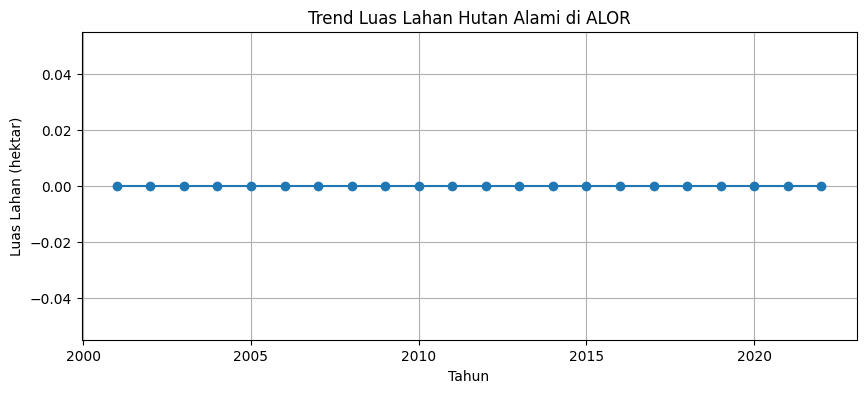


Data Luas Lahan untuk Wilayah: BANDA ACEH (KOTA)


,year,natural_forest_area_hectares
19,2001,0.0
508,2002,0.0
997,2003,0.0
1486,2004,0.0
1975,2005,0.0
2464,2006,0.0
2953,2007,0.0
3442,2008,0.0
3931,2009,0.0
4420,2010,0.0


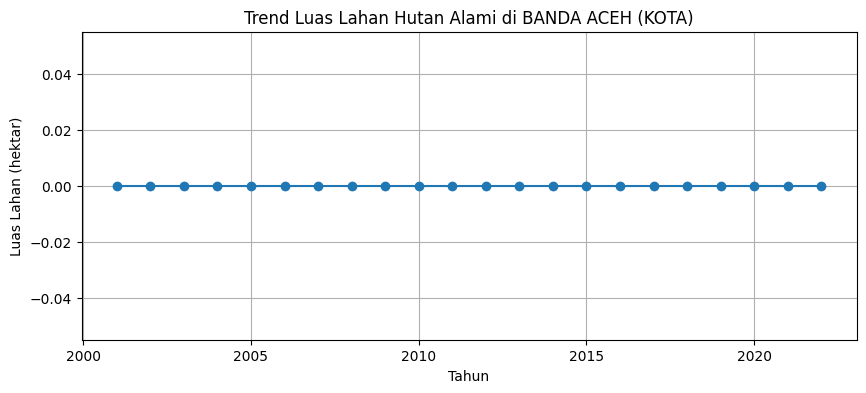


Data Luas Lahan untuk Wilayah: BANDAR LAMPUNG (KOTA)


,year,natural_forest_area_hectares
20,2001,0.0
509,2002,0.0
998,2003,0.0
1487,2004,0.0
1976,2005,0.0
2465,2006,0.0
2954,2007,0.0
3443,2008,0.0
3932,2009,0.0
4421,2010,0.0


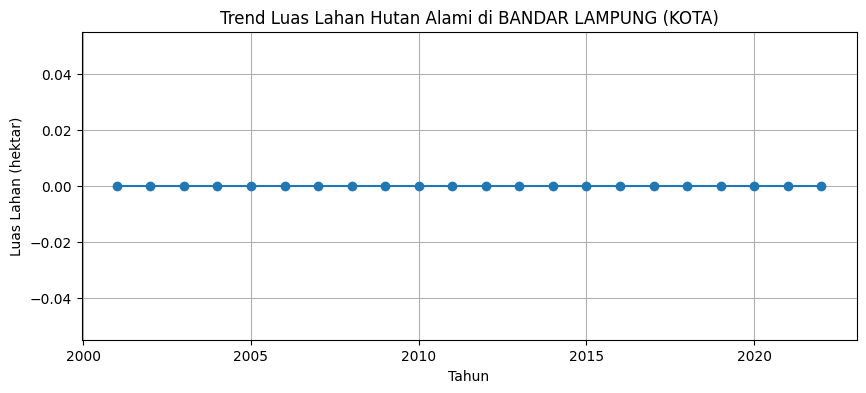


Perbandingan Statistik Deskriptif (dengan dan tanpa nilai 0)

Statistik Deskriptif (Termasuk Nilai 0):


,natural_forest_area_hectares
count,1.075800e+04
mean,1.881335e+05
std,4.533565e+05
min,0.000000e+00
25%,3.843282e+01
50%,1.264553e+04
75%,1.335595e+05
max,3.291772e+06



Statistik Deskriptif (Mengecualikan Nilai 0):


,natural_forest_area_hectares
count,8.844000e+03
mean,2.288490e+05
std,4.906110e+05
min,1.817647e-01
25%,2.328184e+03
50%,3.630564e+04
75%,1.977534e+05
max,3.291772e+06


In [14]:
# Analisis Nilai Nol pada 'natural_forest_area_hectares'

# 1. Melihat persebaran nilai 0
print("\n===Analisis Nilai Nol pada 'natural_forest_area_hectares'===")

# Jumlah total baris dengan nilai 0 pada kolom luas lahan
count_zero_area = len(df[df['natural_forest_area_hectares'] == 0])
print(f"\nJumlah baris dengan luas lahan 0: {count_zero_area}")
print(f"Persentase baris dengan luas lahan 0: {(count_zero_area / len(df)) * 100:.2f}%")

# Melihat tahun-tahun di mana nilai 0 muncul
print("\nTahun-tahun dengan nilai luas lahan 0:")
print(df[df['natural_forest_area_hectares'] == 0]['year'].value_counts().sort_index())

# Melihat wilayah (region) di mana nilai 0 muncul paling sering
print("\nWilayah (region) dengan nilai luas lahan 0 terbanyak:")
print(df[df['natural_forest_area_hectares'] == 0]['region'].value_counts().head(10)) # Tampilkan 10 terbanyak

# Melihat parent region di mana nilai 0 muncul paling sering
print("\nParent Region dengan nilai luas lahan 0 terbanyak:")
print(df[df['natural_forest_area_hectares'] == 0]['parent_region'].value_counts().head(10)) # Tampilkan 10 terbanyak

# 2. Membandingkan dengan nilai lain (analisis per wilayah dari waktu ke waktu)
print("\nAnalisis Perubahan Luas Lahan dari Waktu ke Waktu di Wilayah dengan Nilai Nol")

# Ambil contoh wilayah yang memiliki nilai 0
regions_with_zero = df[df['natural_forest_area_hectares'] == 0]['region'].unique()

# Ambil beberapa contoh wilayah (misal 3 wilayah pertama) untuk dilihat detailnya
sample_regions_to_plot = regions_with_zero[:3]

for region in sample_regions_to_plot:
    print(f"\nData Luas Lahan untuk Wilayah: {region}")
    region_data = df[df['region'] == region].sort_values('year')
    display(region_data[['year', 'natural_forest_area_hectares']])

    # Visualisasi trend luas lahan per wilayah sampel
    plt.figure(figsize=(10, 4))
    plt.plot(region_data['year'], region_data['natural_forest_area_hectares'], marker='o')
    plt.title(f"Trend Luas Lahan Hutan Alami di {region}")
    plt.xlabel("Tahun")
    plt.ylabel("Luas Lahan (hektar)")
    plt.grid(True)
    plt.show()


# 3. Melihat data deskriptif (membandingkan dengan/tanpa nilai 0)
print("\nPerbandingan Statistik Deskriptif (dengan dan tanpa nilai 0)")

print("\nStatistik Deskriptif (Termasuk Nilai 0):")
display(df['natural_forest_area_hectares'].describe())

print("\nStatistik Deskriptif (Mengecualikan Nilai 0):")
# Filter DataFrame untuk mengecualikan baris dengan nilai 0 di kolom luas lahan
df_no_zero_area = df[df['natural_forest_area_hectares'] > 0]
display(df_no_zero_area['natural_forest_area_hectares'].describe())

DataFrame agregasi berdasarkan Provinsi (Parent Region):


,year,parent_region,natural_forest_area_hectares
0,2001,ACEH,3.624507e+06
1,2001,BALI,6.375161e+04
2,2001,BANTEN,6.599245e+04
3,2001,BENGKULU,2.682920e+05
4,2001,D I YOGYAKARTA,1.080000e+01



Menampilkan seluruh DataFrame df_provinsi:


,year,parent_region,natural_forest_area_hectares
0,2001,ACEH,3.624507e+06
1,2001,BALI,6.375161e+04
2,2001,BANTEN,6.599245e+04
3,2001,BENGKULU,2.682920e+05
4,2001,D I YOGYAKARTA,1.080000e+01
...,...,...,...
743,2022,SULAWESI TENGGARA,1.510113e+06
744,2022,SULAWESI UTARA,6.622708e+05
745,2022,SUMATERA BARAT,2.301373e+06
746,2022,SUMATERA SELATAN,7.562253e+05



Informasi DataFrame agregasi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          748 non-null    int64  
 1   parent_region                 748 non-null    object 
 2   natural_forest_area_hectares  748 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.7+ KB

Trend Total Luas Hutan per Provinsi (Contoh beberapa provinsi):


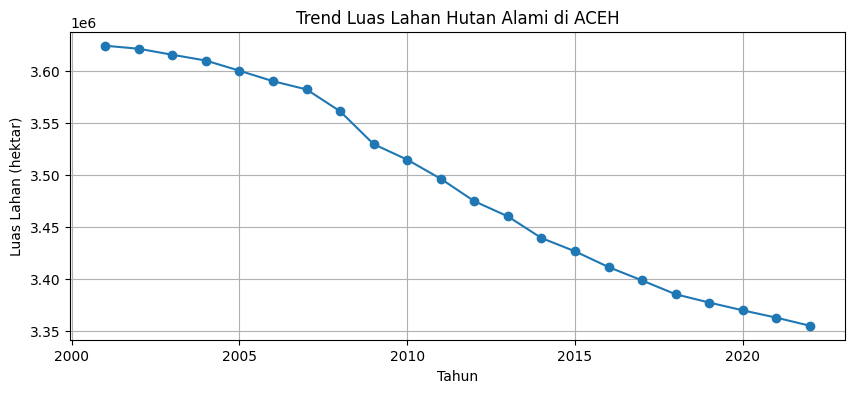

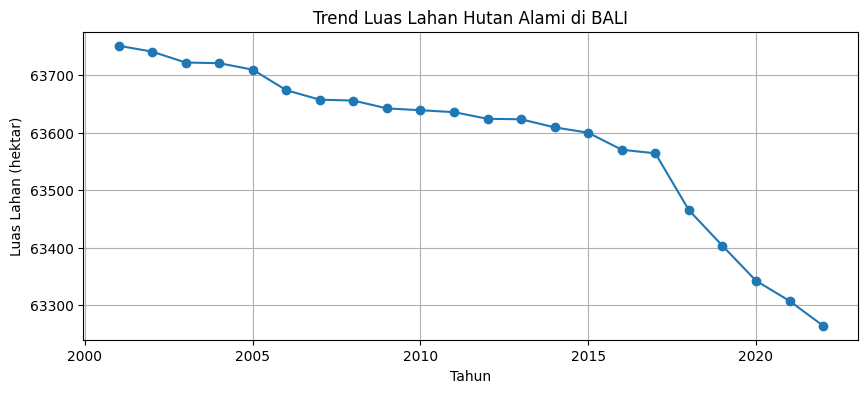

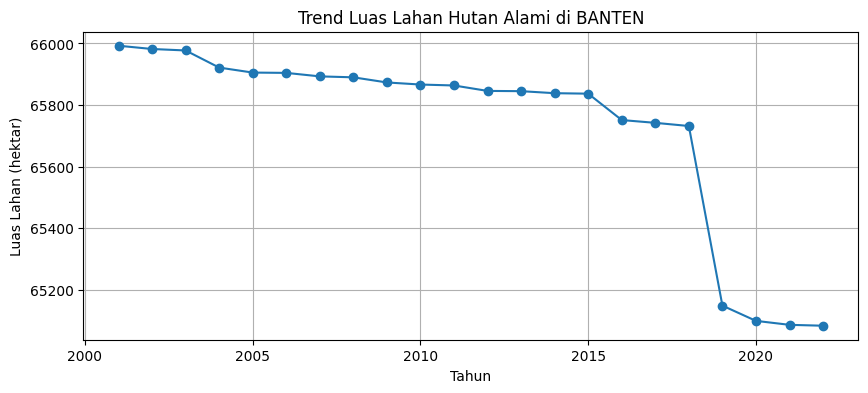

In [24]:
# Pastikan df tidak None sebelum melanjutkan agregasi
if df is not None:
    # Agregasi berdasarkan 'year' dan 'parent_region'
    df_provinsi = df.groupby(['year', 'parent_region'])['natural_forest_area_hectares'].sum().reset_index()

    # Tampilkan beberapa baris pertama dari DataFrame hasil agregasi
    print("DataFrame agregasi berdasarkan Provinsi (Parent Region):")
    display(df_provinsi.head(5))

    # Untuk menampilkan seluruh DataFrame df_provinsi
    print("\nMenampilkan seluruh DataFrame df_provinsi:")
    display(df_provinsi)

    # Anda juga bisa mengecek informasi dasar dari DataFrame baru ini
    print("\nInformasi DataFrame agregasi:")
    df_provinsi.info()

    # Melihat trend total luas hutan per provinsi dari waktu ke waktu
    print("\nTrend Total Luas Hutan per Provinsi (Contoh beberapa provinsi):")
    # Ambil beberapa contoh provinsi untuk visualisasi
    sample_parent_regions = df_provinsi['parent_region'].unique()[:3] # Ambil 3 provinsi pertama

    for parent_region in sample_parent_regions:
        plt.figure(figsize=(10, 4))
        provinsi_data = df_provinsi[df_provinsi['parent_region'] == parent_region].sort_values('year')
        plt.plot(provinsi_data['year'], provinsi_data['natural_forest_area_hectares'], marker='o')
        plt.title(f"Trend Luas Lahan Hutan Alami di {parent_region}")
        plt.xlabel("Tahun")
        plt.ylabel("Luas Lahan (hektar)")
        plt.grid(True)
        plt.show()
else:
    print("DataFrame tidak tersedia. Mohon periksa kembali langkah memuat data.")